### Instructions

**To test the pretrained model:**

1.   Run code chunks 1, 2b and 3
2.   Run code chunks 7 - 9

**To train and test a new model:**
1.   Run code chunks 1 - 6 (Training phase)
2.   Run code chunks 8 - 9 (Testing phase)

**Note:** For training and testing of a new model, run code chunk 2b if you wish to handle the full data, otherwise run code chunk 2a

In [ ]:
# 1. Setting up
# Import necessary packages
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
import requests
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer
from google.colab import drive
import random
import shutil

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# 2a. Getting sample data from GitHub
# Run this code chunk if you only want to handle a small amount of data (instead of the full data)

# Create necessary directories
data_path = Path("data/")
image_path = data_path / "samples"
if image_path.is_dir():
  print(f"{image_path} directory already exists...")
else:
  print(f"{image_path} directory does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
  print(f"{image_path} directory created!")

# Request from GitHub
with open(data_path / "samples.zip", "wb") as file:
  request = requests.get("https://github.com/chiabingxuan/Celebrity-Facial-Recognition-AI/raw/main/data/samples.zip")
  print("Downloading data...")
  file.write(request.content)

# Unzip the zip file
with zipfile.ZipFile(data_path / "samples.zip", "r") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(image_path)
print("Download completed!")

data/samples directory already exists...
Unzipping data...
Download completed!


In [ ]:
# 2b. Getting full data
# Run this code chunk if you want to handle all the data

# Create necessary directories
data_path = Path("data/")
image_path = data_path / "full_data"
if image_path.is_dir():
  print(f"{image_path} directory already exists...")
else:
  print(f"{image_path} directory does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
  print(f"{image_path} directory created!")

# Access zip file via Google Drive and unzip it
drive.mount("/content/drive")
with zipfile.ZipFile("/content/drive/MyDrive/celebrity_recognition_ai/full_data.zip", "r") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(image_path)
print("Download completed!")

data/full_data directory does not exist, creating one...
data/full_data directory created!
Mounted at /content/drive
Unzipping data...
Download completed!


In [ ]:
# 3. Getting Datasets and DataLoaders
# Set up training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

# Select a transform for the images
data_transform = v2.Compose([
    v2.Resize(size=(256, 256)),   # resize images
    v2.TrivialAugmentWide(num_magnitude_bins=31),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ColorJitter(),
    v2.ToTensor()
])

data_transform_test = v2.Compose([
    v2.Resize(size=(256, 256)),   # resize images
    v2.ToTensor()
])

# Loading image data using ImageFolder
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,   # transform for the data
                                  target_transform=None)      # transform for the labels
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform_test,   # transform for the data
                                 target_transform=None)      # transform for the labels
class_names = train_data.classes

# Creating DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# 4. Preparing model training
# Function for training loop
def train_step(model, dataloader, loss_fn, optimiser, scheduler, device=device):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)
  scheduler.step()
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

# Function for testing loop
def test_step(model, dataloader, loss_fn, device=device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  return test_loss, test_acc

# Function that combines training and testing loop, returning model results
def train(model, train_dataloader, test_dataloader, optimiser, scheduler, loss_fn, epochs, device=device):
  results = {"train_loss": list(),
             "train_acc": list(),
             "test_loss": list(),
             "test_acc": list()}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimiser, scheduler, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

# Function that takes in model results and plots loss / accuracy curves against number of epochs
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results["train_loss"]))
  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train loss")
  plt.plot(epochs, test_loss, label="test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train accuracy")
  plt.plot(epochs, test_accuracy, label="test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 4.0108 | Train accuracy: 0.0906 | Test loss: 2.8602 | Test accuracy: 0.2980
Epoch: 1 | Train loss: 2.8918 | Train accuracy: 0.2785 | Test loss: 2.0812 | Test accuracy: 0.4857
Epoch: 2 | Train loss: 2.2061 | Train accuracy: 0.4418 | Test loss: 1.5760 | Test accuracy: 0.6030
Epoch: 3 | Train loss: 1.7361 | Train accuracy: 0.5590 | Test loss: 1.2266 | Test accuracy: 0.6884
Epoch: 4 | Train loss: 1.4060 | Train accuracy: 0.6434 | Test loss: 1.1220 | Test accuracy: 0.6936
Epoch: 5 | Train loss: 1.2033 | Train accuracy: 0.6942 | Test loss: 0.8375 | Test accuracy: 0.7727
Epoch: 6 | Train loss: 1.0257 | Train accuracy: 0.7376 | Test loss: 0.8146 | Test accuracy: 0.7752
Epoch: 7 | Train loss: 0.9213 | Train accuracy: 0.7621 | Test loss: 0.6559 | Test accuracy: 0.8195
Epoch: 8 | Train loss: 0.6628 | Train accuracy: 0.8333 | Test loss: 0.4488 | Test accuracy: 0.8853
Epoch: 9 | Train loss: 0.5718 | Train accuracy: 0.8582 | Test loss: 0.4289 | Test accuracy: 0.8851
Epoch: 10 

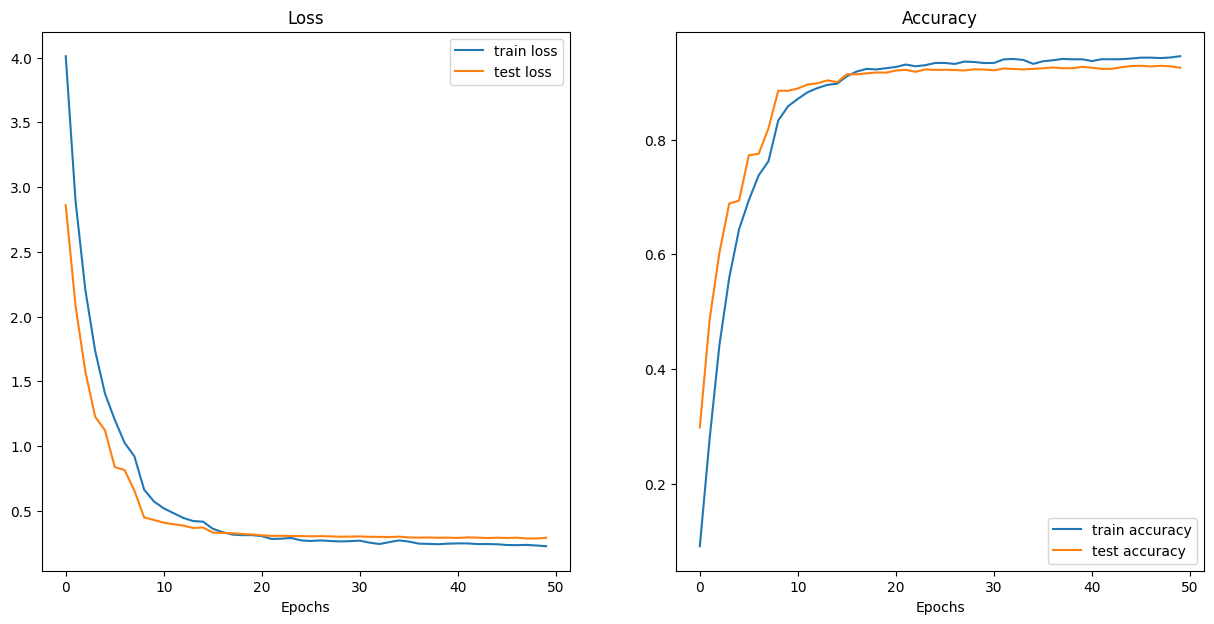

In [ ]:
# 5. Training model
# Instantiate model
model_0 = models.resnet18(weights="IMAGENET1K_V1")
final_connected_layer_in_features = model_0.fc.in_features
model_0.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features=final_connected_layer_in_features, out_features=len(class_names))
)

# Freezing layers (ResNet has 10 children)
NUM_FRONT_LAYERS_TO_FREEZE = 4
children = list(model_0.children())
for count in range(NUM_FRONT_LAYERS_TO_FREEZE):
  child = children[count]
  for param in child.parameters():
    param.requires_grad = False

# Choose loss function, optimiser and scheduler
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.AdamW(params=model_0.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=[8, 15, 20], gamma=0.3)

# Set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Send model to device
model_0.to(device)

# Train model
NUM_EPOCHS = 50
start_time = timer()
model_0_results = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimiser=optimiser, scheduler=scheduler, loss_fn=loss_fn, epochs=NUM_EPOCHS, device=device)
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds")
plot_loss_curves(model_0_results)

In [ ]:
# 6. Save state dict of model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "celebrity_recognition_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
""" Code below is for model testing """

In [ ]:
# 7. Load model (can skip this code chunk if you have trained your own model in previous code chunks)
# Create "models" directory
MODEL_PATH = Path("models")
MODEL_NAME = "celebrity_recognition_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
if MODEL_PATH.is_dir():
  print(f"{MODEL_PATH} directory already exists...")
else:
  print(f"{MODEL_PATH} directory does not exist, creating one...")
  MODEL_PATH.mkdir(parents=True, exist_ok=True)
  print(f"{MODEL_PATH} directory created!")

# Get state dict from Google Drive and place it in "models" directory
shutil.copy("/content/drive/MyDrive/celebrity_recognition_ai/celebrity_recognition_model.pth", MODEL_SAVE_PATH)

# Instantiate new model and load state dict
model_0 = models.resnet18(weights="IMAGENET1K_V1")
final_connected_layer_in_features = model_0.fc.in_features
model_0.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features=final_connected_layer_in_features, out_features=len(class_names))
)
model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH, map_location=torch.device("cpu")))
model_0.to(device)

models directory does not exist, creating one...
models directory created!


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

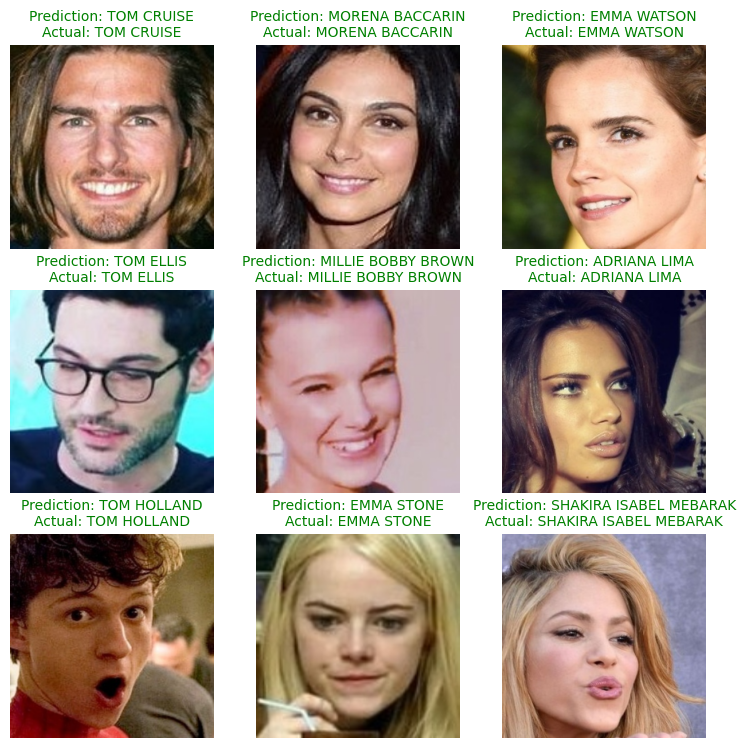

In [33]:
# 8. Predict using randomly chosen images from test data
def make_predictions(model, data, device=device):
  pred_probs = list()
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())    # matplotlib only works on cpu
  return torch.stack(pred_probs)

test_samples = list()
test_labels = list()
selections = random.sample(list(test_data), k=9)   # randomly choose 9 pictures

for sample, label in selections:
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model=model_0, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plotting predictions
plt.figure(figsize=(9, 9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i + 1)
  plt.imshow(sample.squeeze().permute(1, 2, 0), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"Prediction: {pred_label}\nActual: {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);

images directory already exists...


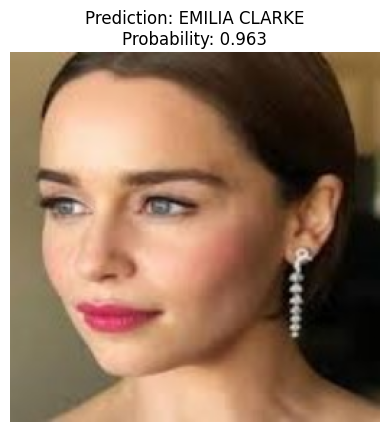

In [32]:
# 9. Predict using custom image
# Create "images" directory
IMAGES_PATH = Path("images")
IMAGES_SAVE_PATH = IMAGES_PATH / "images.jpeg"   # change according to file name of image
if IMAGES_PATH.is_dir():
  print(f"{IMAGES_PATH} directory already exists...")
else:
  print(f"{IMAGES_PATH} directory does not exist, creating one...")
  IMAGES_PATH.mkdir(parents=True, exist_ok=True)
  print(f"{IMAGES_PATH} directory created!")

# Get image from Google Drive and place it in "images" directory
shutil.copy("/content/drive/MyDrive/celebrity_recognition_ai/images.jpeg", IMAGES_SAVE_PATH)   # change according to file name of image

# Select a transform for the image
custom_image_transform = v2.Compose([
    v2.Resize(size=(256, 256)),   # resize images
])

# Functionise custom image prediction
def pred_and_plot_image(model, image_path, class_names=None, transform=None, device=device):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255
  if transform:
    target_image = transform(target_image)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)
    target_image_pred = model(target_image.to(device))
  target_image_pred_probs = target_image_pred.softmax(dim=1)
  target_image_pred_labels = target_image_pred_probs.argmax(dim=1)
  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Prediction: {class_names[target_image_pred_labels.cpu()]}\nProbability: {target_image_pred_probs.max().cpu():.3f}"     # matplotlib can only handle cpu
  else:
    title = f"Prediction: {target_image_pred_labels.cpu()}\nProbability: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);

pred_and_plot_image(model_0, IMAGES_SAVE_PATH, class_names, custom_image_transform, device)